In [1]:
from netCDF4 import Dataset
import numpy as np
from numpy import sin, cos, tan, deg2rad, rad2deg
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy as sc
from scipy import stats
%matplotlib inline

In [2]:
slopeDS = Dataset('/scratch/srai6/EddyKillingPaper3/CESM/afterSlope/slopeAndCorr2D_0100km.nc')
slope2d = np.array(slopeDS.variables['slope'])

In [3]:
ellinkm = 50
#ds = Dataset('/scratch/srai6/EddyKillingPaper3/CESM/tavg_1_7.nc_{0:04d}_Filtered.nc'.format(ellinkm))
ds = Dataset('/scratch/srai6/EddyKillingPaper3/CESM/avg7day.nc_{0:d}._Filtered.nc'.format(ellinkm))
#ds = Dataset('/scratch/srai6/EddyKillingPaper3/CESM/afterSlope/tavg_001_007.nc_0100_Filtered.nc')
ds = Dataset('/scratch/srai6/EddyKillingPaper3/CESM/afterSlope/1.nc_{0:03d}._Filtered_nanland.nc'.format(ellinkm))
dsNLM = Dataset('/scratch/srai6/EddyKillingPaper3/CESM/afterSlope/001_NLmodelEP_0100km.nc')
ds_unfilt = Dataset('/scratch/srai6/EddyKillingPaper3/CESM/tavg_1_7.nc')
gridDS= Dataset('/scratch/srai6/EddyKillingPaper3/CESM/newGlobalGrid_tripolePOP_0.1deg.nc')
gridDS.variables.keys()
print(ds.variables.keys())

dict_keys(['UVEL', 'VVEL', 'SUF', 'SVF', 'TotalPowerPerArea', 'TotalPower', 'MeanPowerPerArea', 'MeanPower', 'EddyPowerPerArea', 'EddyPower'])


In [4]:
def GetGradient_orig(phi, DX, DY, UAREA, xaxis=1, yaxis=0):
    p = -1  ##
    m = 1  ##
    
    topright = np.roll(phi, (p, p), axis=(yaxis, xaxis))
    topleft = np.roll(phi, (p, m), axis=(yaxis, xaxis))

    bottomright = np.roll(phi, (m, p), axis=(yaxis, xaxis))
    bottomleft = np.roll(phi, (m, m), axis=(yaxis, xaxis))

    dx = (np.roll(DX, (0,m), axis=(yaxis, xaxis)) + np.roll(DX, (0,p), axis=(yaxis, xaxis)))
    dy = (np.roll(DY, (m,0), axis=(yaxis, xaxis)) + np.roll(DY, (p,0), axis=(yaxis, xaxis))) 
        
    gradx = (topright + bottomright - topleft - bottomleft)/(dx)
    grady = (topright + topleft - bottomright - bottomleft)/(dy)

    return gradx, grady

def GetGradient_simple(phi, DX, DY, UAREA):
    gradx = np.roll(phi, -1, axis=1) - np.roll(phi, 1, axis=1)
    grady = np.roll(phi, -1, axis=0) - np.roll(phi, 1, axis=0)
    
    dx = DX + (np.roll(DX, -1, axis=1)+np.roll(DX, 1, axis=1))/2
    dy = DY + (np.roll(DY, -1, axis=0)+np.roll(DY, 1, axis=0))/2
    
    gradx/= dx
    grady/= dy
    
    return gradx, grady


def GetGradient_POP(Array2D, DXU, DYU, UAREA):
    delx_phi = Array2D*DXU
    dely_phi = Array2D*DYU

    avgY_dely_phi = 0.5*(dely_phi + np.roll(dely_phi, -1, axis=1)) 
    avgX_delx_phi = 0.5*(delx_phi + np.roll(delx_phi, -1, axis=0))

    delx_stuff = avgY_dely_phi - np.roll(avgY_dely_phi, 1, axis=1)
    dely_stuff = avgX_delx_phi - np.roll(avgX_delx_phi, 1, axis=0)

    gradx = delx_stuff/UAREA
    grady = dely_stuff/UAREA
    
    return gradx, grady

def GetGradient_POP2(Array2D, DXU, DYU, UAREA):
    p = -1
    m = 1
    x = 1
    y = 0
    topRight = 0.25*(Array2D + np.roll(Array2D, p, axis=x) +\
               np.roll(Array2D, (p,p), axis=(y,x)) +\
               np.roll(Array2D, p, axis=y))
    
    topLeft = 0.25*(Array2D + np.roll(Array2D, p, axis=y) +\
               np.roll(Array2D, (p,m), axis=(y,x)) +\
               np.roll(Array2D, m, axis=x))
    
    bottomRight = 0.25*(Array2D + np.roll(Array2D, p, axis=x) +\
               np.roll(Array2D, (m,p), axis=(y,x)) +\
               np.roll(Array2D, m, axis=y))
    
    bottomLeft = 0.25*(Array2D + np.roll(Array2D, m, axis=x) +\
               np.roll(Array2D, (m,m), axis=(y,x)) +\
               np.roll(Array2D, m, axis=y))
    
    gradx = 0.5*(topRight + bottomRight - topLeft - bottomLeft)/DX
    grady = 0.5*(topRight + topLeft - bottomRight - bottomLeft)/DY
    
    return gradx, grady

def GetGradient_POPlike(Array2D, DXU, DYU, UAREA):
    left = 0.5*(Array2D + np.roll(Array2D,1,axis=1))
    right = 0.5*(Array2D + np.roll(Array2D,-1,axis=1))
    
    bottom = 0.5*(Array2D + np.roll(Array2D,1,axis=0))
    top = 0.5*(Array2D + np.roll(Array2D,-1,axis=0))
    
    gradx = (right-left)/DXU
    grady = (top-bottom)/DYU
    
    return gradx, grady
    
    
def GetGradient(phi, DX, DY, UAREA):
    dx_phi, dy_phi = GetGradient_POP2(phi, DX, DY, UAREA)     
    return dx_phi, dy_phi


def log_to_sph(U_log, V_log, ANGLE):
    #ANGLE in radians
    U_Sph = U_log * np.cos(ANGLE) - V_log * np.sin(ANGLE)
    V_Sph = U_log * np.sin(ANGLE) + V_log * np.cos(ANGLE)
    return U_Sph, V_Sph


def sph_to_log(U_Sph, V_Sph, ANGLE):
    #ANGLE in radians logical direction w.r.t. lat line
    U_Log = U_Sph * np.cos(ANGLE) + V_Sph * np.sin(ANGLE)
    V_Log = V_Sph * np.cos(ANGLE) - U_Sph * np.sin(ANGLE)
    return U_Log, V_Log

def getSphToCart(u, v, latInDeg, lonInDeg):
    w = 0.0
    
    ulat = deg2rad(latInDeg)
    ulon = deg2rad(lonInDeg)
    
    uc = w*cos(ulon)*cos(ulat) - u*sin(ulon) - v*cos(ulon)*sin(ulat)
    vc = w*sin(ulon)*cos(ulat) + u*cos(ulon) - v*sin(ulon)*sin(ulat)
    wc = w*sin(ulat) + v*cos(ulat)
    
    return uc, vc, wc


def getGradVecSph2D(u_log, v_log, DXU, DYU, ANGLE, UAREA, phi):
    R = 6.378e8
    dx_u_log, dy_u_log = GetGradient(u_log, DXU, DYU, UAREA)
    dx_v_log, dy_v_log = GetGradient(v_log, DXU, DYU, UAREA)
    
    dx_u, dy_u = log_to_sph(dx_u_log, dy_u_log, ANGLE)
    dx_v, dy_v = log_to_sph(dx_v_log, dy_v_log, ANGLE)
    
    u, v = log_to_sph(u_log, v_log, ANGLE)
#     plt.pcolormesh(u)
#     plt.colorbar()
    
    ii = dx_u - v*tan(phi)/R
    ij = dx_v + u*tan(phi)/R
    ik = -u/R
    ji = dy_u
    jj = dy_v
    jk = -v/R
    ki = 0
    kj = 0
    kk = 0
    
    return np.stack((ii, ij, ik, ji, jj, jk), axis=0) # ki, kj, kk


def getModelVal(taux_bar, tauy_bar, u_bar, v_bar, DX, DY, UAREA, ellinkm):
    C2dict = {'40': 0.25030,
              '50': 0.20579,
              '60': 0.18137,
              '80': 0.15688,
             '100': 0.14546,
             '150': 0.13412}
    
    C_2 = C2dict[str(ellinkm)] #0.125 ### value for 2d plane surface , maybe calculate for spherical surface
    dx_u, dy_u = GetGradient(u_bar, DX, DY, UAREA)
    dx_v, dy_v = GetGradient(v_bar, DX, DY, UAREA)

    dx_taux, dy_taux = GetGradient(taux_bar, DX, DY, UAREA)
    dx_tauy, dy_tauy = GetGradient(tauy_bar, DX, DY, UAREA)

    # model  =  d_j tau_i d_j u_i
    model = dx_taux * dx_u +\
            dy_taux * dy_u +\
            dx_tauy * dx_v +\
            dy_tauy * dy_v
    
    strainVel_11 = 1/2 * (dx_u + dx_u)
    strainVel_12 = 1/2 * (dx_v + dy_u)
    strainVel_21 = strainVel_12
    strainVel_22 = 1/2 * (dy_v + dy_v)

    rotateVel_12 = 1/2 * (dx_v - dy_u)
    rotateVel_21 = -1*rotateVel_12


    strainTau_11 = 1/2 * (dx_taux + dx_taux)
    strainTau_12 = 1/2 * (dx_tauy + dy_taux)
    strainTau_21 = strainTau_12
    strainTau_22 = 1/2 * (dy_tauy + dy_tauy)

    rotateTau_12 = 1/2 * (dx_tauy - dy_taux)
    rotateTau_21 = -1*rotateTau_12


    strainPart = strainVel_11 * strainTau_11 + strainVel_12 * strainTau_12 + strainVel_21 * strainTau_21 + strainVel_22 * strainTau_22
    
    rotatePart = rotateVel_12 * rotateTau_12 + rotateVel_21 * rotateTau_21

    model *= 1/2 * (ellinkm*1e5)**2 * C_2
    strainPart  *= 1/2 * (ellinkm*1e5)**2 * C_2
    rotatePart *= 1/2 * (ellinkm*1e5)**2 * C_2

    return model, rotatePart, strainPart

def getModel2(taux_bar, tauy_bar, u_bar, v_bar, DX, DY, UAREA, ULAT, ULONG, ellinkm):
    C_2 = 0.14556 #0.125 ### value for 2d plane surface , maybe calculate for spherical surface
    
    u_bar, v_bar, w_bar = getSphToCart(u_bar, v_bar, ULAT, ULONG)
    taux_bar, tauy_bar, tauz_bar = getSphToCart(taux_bar, tauy_bar, ULAT, ULONG)
    
    dx_u, dy_u = GetGradient(u_bar, DX, DY, UAREA)
    dx_v, dy_v = GetGradient(v_bar, DX, DY, UAREA)
    dx_w, dy_w = GetGradient(w_bar, DX, DY, UAREA)

    dx_taux, dy_taux = GetGradient(taux_bar, DX, DY, UAREA)
    dx_tauy, dy_tauy = GetGradient(tauy_bar, DX, DY, UAREA)
    dx_tauz, dy_tauz = GetGradient(tauz_bar, DX, DY, UAREA)

    # model  =  d_j tau_i d_j u_i
    model = dx_taux * dx_u +\
            dy_taux * dy_u +\
            dx_tauy * dx_v +\
            dy_tauy * dy_v +\
            dx_tauz * dx_w +\
            dy_tauz * dy_w


    model *= 1/2 * (ellinkm*1e5)**2 * C_2
    return model

def getModel3(uvel, vvel, taux, tauy, DX, DY, ANGLE, ellInKm, ULAT):
    M2 = 0.14556
    
    ylen, xlen = uvel.shape
    grad_vel = np.zeros((6, ylen, xlen), dtype=float)
    grad_tau = np.zeros((6, ylen, xlen), dtype=float)
    
    grad_vel = getGradVecSph2D(uvel, vvel, DX, DY, ANGLE, UAREA, np.deg2rad(ULAT))
    grad_tau = getGradVecSph2D(taux, tauy, DX, DY, ANGLE, UAREA, np.deg2rad(ULAT))
    
    model = np.zeros(uvel.shape, dtype=float)
    
    for i in range(6):
        model += grad_vel[i,:,:] * grad_tau[i,:,:]
    
    model *=  1/2 * M2* (ellInKm*1e5)**2
    
    return model

In [21]:
# u = ds.variables['UVEL'][0,:,:]
# v = ds.variables['VVEL'][0,:,:]
# tx = ds.variables['SUF'][0,:,:]
# ty = ds.variables['SVF'][0,:,:]

# u = ds.variables['UVEL'][0,:,:]
# v = ds.variables['VVEL'][0,:,:]
# tx = ds.variables['SUF'][0,:,:]
# ty = ds.variables['SVF'][0,:,:]
# EPPA = ds.variables['EddyPowerPerArea'][0,:,:]


DX = np.array(gridDS.variables['DXU'])
DY = np.array(gridDS.variables['DYU'])
KMT = np.array(gridDS.variables['KMT'])
ANGLE = np.array(gridDS.variables['ANGLE'])
ANGLE[abs(ANGLE)>180] = 0.0
landMask = KMT < 1 #

UAREA = np.array(gridDS.variables['UAREA'])
ULONG = np.array(gridDS.variables['ULONG'])
ULAT = np.array(gridDS.variables['ULAT'])
angleMask = abs(ULAT) > 80

ubar = ds.variables['UVEL'][:,:]
vbar = ds.variables['VVEL'][:,:]
tx = ds.variables['SUF'][:,:]
ty = ds.variables['SVF'][:,:]

ubar, vbar = sph_to_log(ubar, vbar, ANGLE)

mask = landMask + angleMask

mask += abs(ubar)>1000
mask += abs(vbar)>1000
mask += abs(tx)>1000
mask += abs(ty)>1000

ubar, vbar = sph_to_log(ubar, vbar, ANGLE)

ubar[mask] = float('nan')
vbar[mask] = float('nan')

tx[mask] = float('nan')

ty[mask] = float('nan')

tx, ty = sph_to_log(tx, ty, ANGLE)

EPPA = ds.variables['EddyPowerPerArea'][:,:]
mask += EPPA == 0
EPPA[mask] = float('nan')

NLM = np.array(dsNLM.variables['NLmodel_EPCg'][0,:,:])
NLM[mask] = float('nan')

In [22]:
ubar.shape

(2400, 3600)

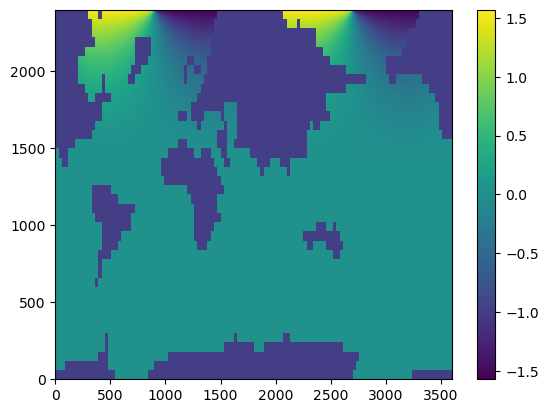

In [23]:
plt.pcolormesh(ANGLE)
plt.colorbar()

In [24]:
model, rotPar, strPart = getModelVal(tx, ty, ubar, vbar, DX, DY, UAREA, ellinkm)
#model = getModel2(tx, ty, ubar, vbar, DX, DY, UAREA, ULAT, ULONG, ellinkm)

# ratio = EPPA/model

# mask += abs(ratio) > 5
mask += np.isnan(model)
# mask += abs(EPPA)>50
# mask += abs(model)>50

EPPA[mask] = float('nan')
model[mask] = float('nan')

# EPPA[angleMask] = float('nan')
# model[angleMask] = float('nan')

# valMask = (abs(model) > 100) + (abs(EPPA) > 100)
# EPPA[valMask] = float('nan')
# model[valMask] = float('nan')
# model3[valMask] = float('nan')

u = ds_unfilt.variables['UGOS'][0,:,:]
v = ds_unfilt.variables['VGOS'][0,:,:]
u[mask] = float('nan')
v[mask] = float('nan')

# tx = ds.variables['SUF'][0,:,:]
# ty = ds.variables['SVF'][0,:,:]

0.8807519434787218


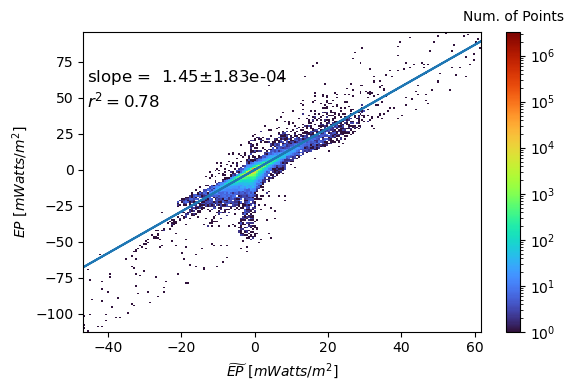

In [25]:
y = EPPA.flatten()
x = model.flatten()
msk = np.isnan(x) + np.isnan(y)
msk1 = np.isinf(x) + np.isinf(y)
#msk2 = (x == 0) + (y ==0)
msk += msk1# + msk2
x = x[~msk]
y = y[~msk]
r = np.corrcoef(x,y)[0, 1]
print(r)

slope, intercept, r_value, p_value, std_err = stats.linregress(
                    x, y)
stdev_x = np.std(x)
stdev_y = np.std(y)

prob = 0.95
Npoints = len(x)
t_star = stats.t.cdf(1 - (1-prob)/2, Npoints - 1)
std_err *= t_star * stdev_x/stdev_y

corr_coeff = np.corrcoef(x, y)[0,1]

cbTitle = 'Num. of Points'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))


regress_model = slope * x + intercept

slope_text = r'slope = {0:5.2f}'.format(slope)
err_text = r'$\pm$' + '{0:5.2e}'.format(std_err)
rsq_text = r'$r^2 = {0:4.2f}$'.format(r_value**2)
str_text = slope_text + err_text + '\n' + rsq_text

hist2d = ax.hist2d(x, y, bins=(200, 200), cmap='turbo',
                   rasterized=True, norm=colors.LogNorm())

cb = plt.colorbar(hist2d[3], ax = ax)
cb.ax.tick_params(labelsize=10)
cb.ax.set_title(cbTitle, size=10, pad = 8)

ax.set_xlabel(r'$\widetilde{EP}~[mWatts/m^2]$', fontsize=10)
ax.set_ylabel(r'$EP~[mWatts/m^2]$', fontsize=10)
ax.plot(x, regress_model, rasterized=True)

ax.text(0.01, 0.75, str_text, horizontalalignment='left', 
        transform=ax.transAxes, rasterized=True, fontsize=12)
plt.tight_layout()
plt.savefig('CESM_NLMvsEP_slope{0:d}.pdf'.format(ellinkm), dpi=70)

In [26]:
model *= slope
rotPar *= slope
strPart *= slope
NLM *= slope

0.9578039624796687
-1.9239967427395581
-1.3687532890627663
-35.31605578612736
-22.289549391652017
-6.76511711733914


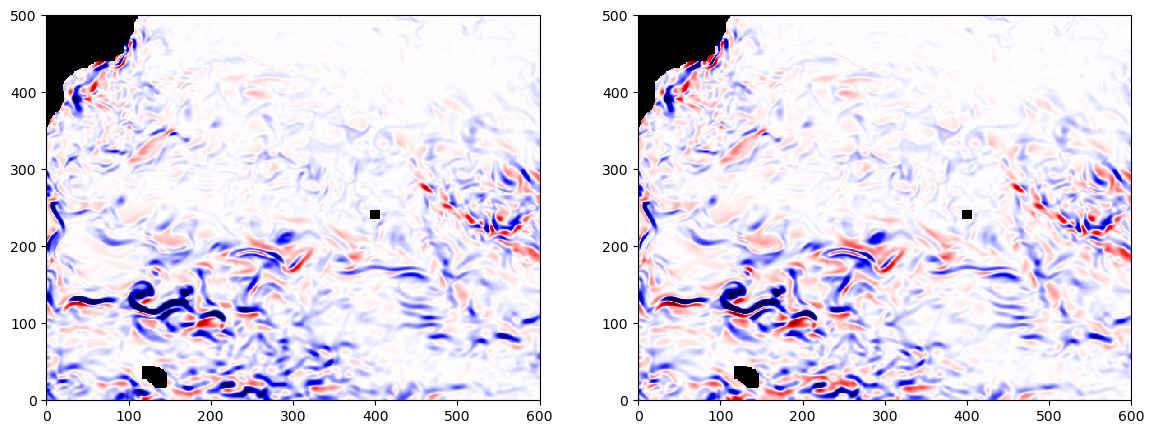

In [27]:
cmap = plt.get_cmap('seismic').copy()
cmap.set_bad('k')

y1, y2 = 500, 1000 
x1, x2 = 600, 1200 

d = 3
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax[0].pcolormesh(EPPA[y1:y2, x1:x2], vmin=-d, vmax=d, cmap=cmap)
m = ax[1].pcolormesh(model[y1:y2, x1:x2], vmin=-d, vmax=d, cmap=cmap)
#plt.colorbar(m, ax = ax[1])

x = EPPA[y1:y2, x1:x2].flatten()
y = model[y1:y2, x1:x2].flatten()
msk = np.isnan(x) + np.isnan(y)
msk1 = np.isinf(x) + np.isinf(y)
msk2 = (x == 0) + (y ==0)
msk += msk1 + msk2
x = x[~msk]
y = y[~msk]
r = np.corrcoef(x,y)[0, 1]
print(r)
print(np.nansum(UAREA[y1:y2, x1:x2] * EPPA[y1:y2, x1:x2])*1e-7/1e9)
print(np.nansum(UAREA[y1:y2, x1:x2] * model[y1:y2, x1:x2])*1e-7/1e9)

print(np.nansum(UAREA * EPPA)*1e-7/1e9)
print(np.nansum(UAREA * model)*1e-7/1e9)
print(np.nansum(UAREA * NLM)*1e-7/1e9)

0.9712225141857809
-0.496341721546752
-0.5091005778184047


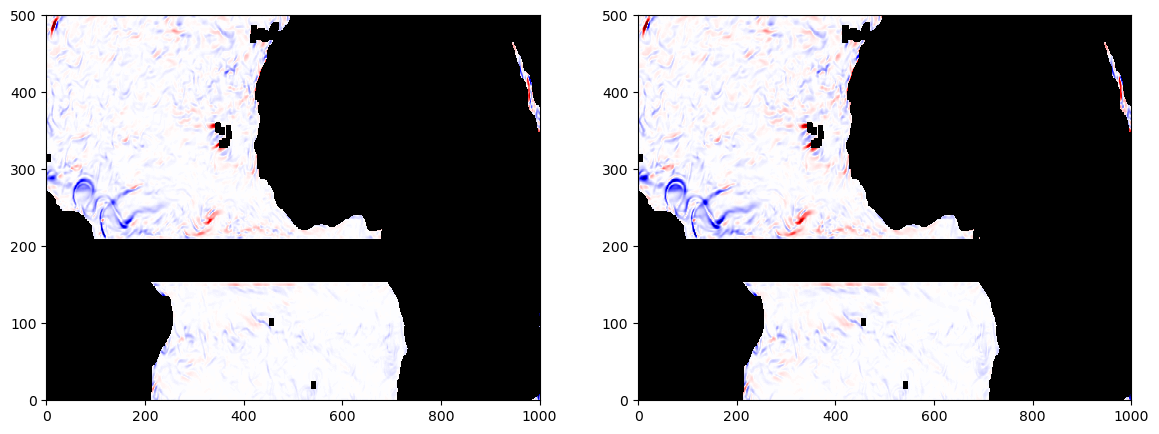

In [28]:
y1, y2 = 1000, 1500 
x1, x2 = 500, 1500 

d = 2
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax[0].pcolormesh(EPPA[y1:y2, x1:x2], vmin=-d, vmax=d, cmap=cmap)
ax[1].pcolormesh(model[y1:y2, x1:x2], vmin=-d, vmax=d, cmap=cmap)

n=0
x = EPPA[y1:y2, x1:x2].flatten()
y = model[y1:y2, x1:x2].flatten()
msk = np.isnan(x) + np.isnan(y)
msk1 = np.isinf(x) + np.isinf(y)
msk2 = (x == 0) + (y ==0)
msk += msk1 + msk2
x = x[~msk]
y = y[~msk]
r = np.corrcoef(x,y)[0, 1]
print(r)

print(np.nansum(UAREA[y1:y2, x1:x2] * EPPA[y1:y2, x1:x2])*1e-7/1e9)
print(np.nansum(UAREA[y1:y2, x1:x2] * model[y1:y2, x1:x2])*1e-7/1e9)

0.9239479697509109


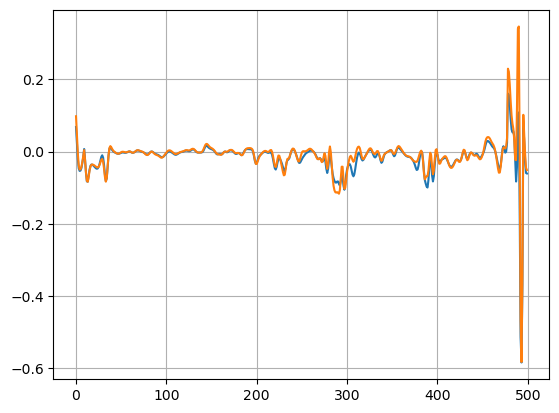

In [13]:
n1 = 0
n2 = 500#len(x)
plt.plot(x[n1:n2])
plt.plot(y[n1:n2])
plt.grid('on')
print(np.corrcoef(x[n1:n2], y[n1:n2])[0, 1])

250


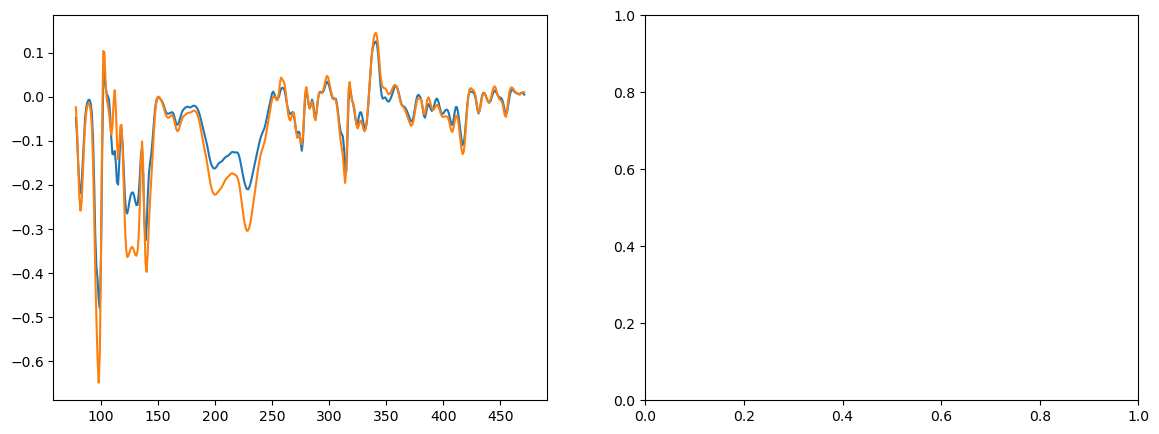

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
yindx = (y1+y2)//2
print(yindx-y1)
ax[0].plot(EPPA[yindx, x1:x2])
ax[0].plot(model[yindx, x1:x2])

In [15]:
# import cartopy.crs as ccrs

# ax = plt.axes(projection=ccrs.PlateCarree());
# ax.pcolormesh(ULAT[y1:y2, x1:x2], ULONG[y1:y2, x1:x2], EPPA[y1:y2, x1:x2], transform=ccrs.PlateCarree());


# d = 4
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

# x1, x2 = 600, 1200
# y1, y2 = 500, 1000
# ax[0].pcolormesh(ULAT[y1:y2, x1:x2], ULONG[y1:y2, x1:x2], EPPA[y1:y2, x1:x2], vmin=-d, vmax=d, cmap='seismic')
# ax[1].pcolormesh(ULAT[y1:y2, x1:x2], ULONG[y1:y2, x1:x2], model[y1:y2, x1:x2], vmin=-d, vmax=d, cmap='seismic')

# x = EPPA[500:1000,600:1200].flatten()
# y = model[500:1000,600:1200].flatten()
# msk = np.isnan(x) + np.isnan(y)
# r = np.corrcoef(x[~msk], y[~msk])[0, 1]
# print(r)

0.9524199288330382


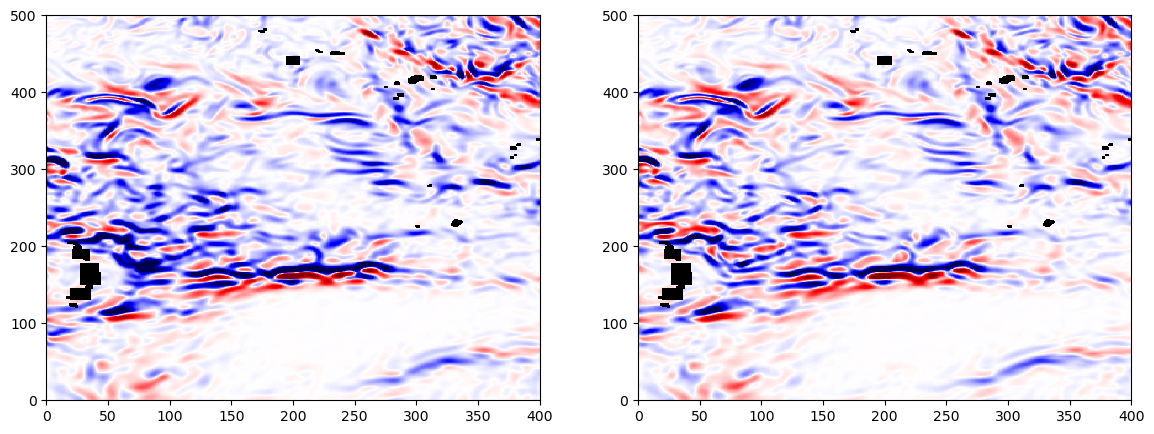

In [16]:

y1, y2 = 300, 800
x1, x2 = 800, 1200


d = 2


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))


ax[0].pcolormesh(EPPA[y1:y2, x1:x2], vmin=-d, vmax=d, cmap=cmap)
ax[1].pcolormesh(model[y1:y2, x1:x2], vmin=-d, vmax=d, cmap=cmap)

x = EPPA[y1:y2, x1:x2].flatten()
y = model[y1:y2, x1:x2].flatten()
msk = np.isnan(x) + np.isnan(y)
r = np.corrcoef(x[~msk], y[~msk])[0, 1]
print(r)

0.9524199288330382
-4.643755147657216 -2.465332644432571


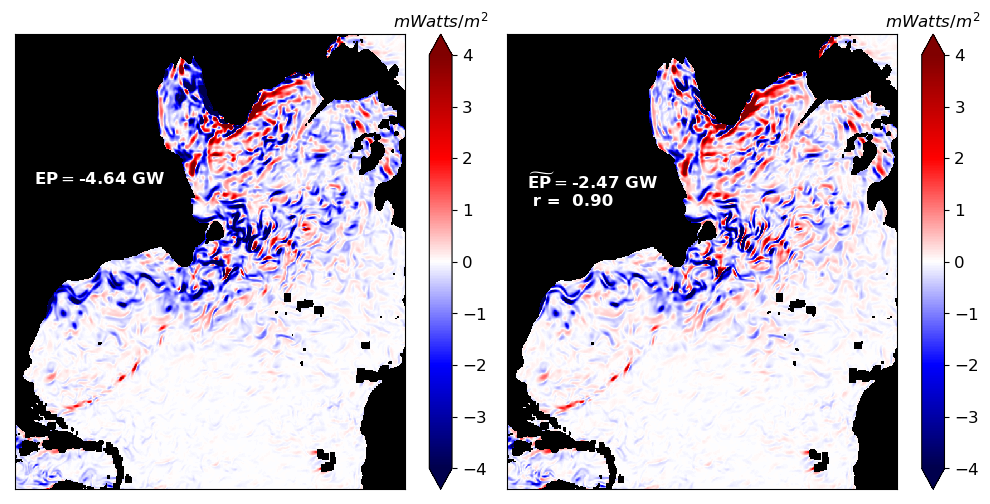

In [17]:
y1 = 1300
y2 = 2000
x1 = 300
x2 = 1000
       
    
x = EPPA[y1:y2,x1:x2].flatten()
y = model[y1:y2,x1:x2].flatten()
msk = np.isnan(x) + np.isnan(y)
r_local = np.corrcoef(x[~msk], y[~msk])[0, 1]

d = 4
xpos = 0.05
ypos = 0.70
fsize = 12
cbTitle = r'$mWatts/m^2$'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax =axes[0]
m = ax.pcolormesh(EPPA[y1:y2,x1:x2], vmin=-d, vmax=d, cmap=cmap, rasterized=True)
txt = r'$\mathbf{EP} = $' + '{0:5.2f} GW'.format(np.nansum(EPPA[y1:y2,x1:x2]*UAREA[y1:y2,x1:x2]*1e-7/1e9))
ax.text(xpos, ypos, txt, horizontalalignment='left', fontweight = 'heavy',  color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
cb = plt.colorbar(m, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
cb.ax.set_title(cbTitle, size=12, pad = 20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


ax =axes[1]
m = ax.pcolormesh(model[y1:y2,x1:x2], vmin=-d, vmax=d, cmap=cmap, rasterized=True)
txt1 = r'$\mathbf{\widetilde{EP}} = $' + '{0:5.2f} GW'.format(np.nansum(model[y1:y2,x1:x2]*UAREA[y1:y2,x1:x2]*1e-7/1e9))
txt2 = '\n r = {0:5.2f}'.format(r_local)
txt = txt1 + txt2
ax.text(xpos, ypos, txt, horizontalalignment='left', fontweight = 'heavy',  color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
cb = plt.colorbar(m, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
cb.ax.set_title(cbTitle, size=12, pad = 20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


print(r)
print(np.nansum(EPPA[y1:y2,x1:x2] * UAREA[y1:y2,x1:x2])*(1e-16), 
      np.nansum(model[y1:y2,x1:x2] * UAREA[y1:y2,x1:x2])*(1e-16))

plt.subplots_adjust(left=0.02, bottom=0.02, right=1, top=0.93, wspace=0.01, hspace=0.01)

plt.savefig('CESM_gulf_ModelVsEP_{0:d}.pdf'.format(ellinkm), dpi= 70)

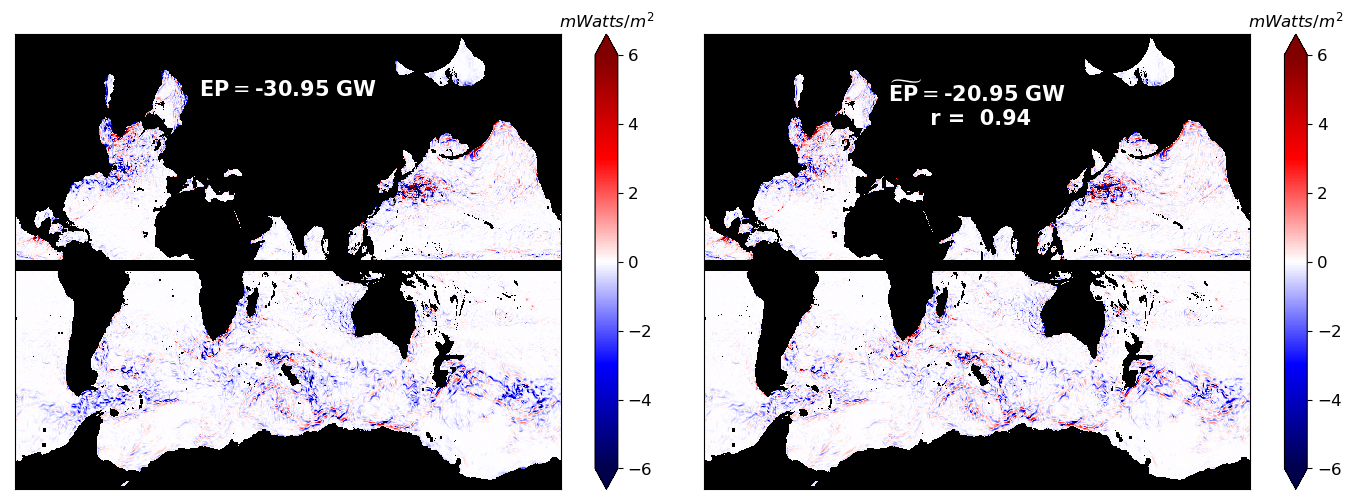

In [18]:
msk1 = np.isnan(EPPA)  + (abs(EPPA)>1e5)
msk2 = np.isnan(model) +(abs(model)>1e5)
msk3 = np.isnan(UAREA) +(abs(UAREA)>1e20)

msk = msk1*msk2*msk3
EPPA[msk] = float('nan')
model[msk] = float('nan')

cmap = plt.get_cmap('seismic').copy()
cmap.set_bad('k')

d = 6
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))


xpos = 0.5
ypos = 0.90
fsize = 15
cbTitle = r'$mWatts/m^2$'
ax = axes[0]
m = ax.pcolormesh(EPPA, vmin=-d, vmax=d, cmap=cmap, rasterized=True)
txt = r'$\mathbf{EP} = $' + '{0:5.2f} GW'.format(np.nansum(EPPA*UAREA*1e-7/1e9))
ax.text(xpos, ypos, txt, horizontalalignment='center', fontweight = 'heavy', color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
cb = plt.colorbar(m, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
cb.ax.set_title(cbTitle, size=12, pad = 20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = axes[1]
m = ax.pcolormesh(model, vmin=-d, vmax=d, cmap=cmap, rasterized=True)
txt1 = r'$\mathbf{\widetilde{EP}} = $' + '{0:5.2f} GW'.format(np.nansum(model*UAREA*1e-7/1e9))
txt2 = '\n r = {0:5.2f}'.format(corr_coeff)
txt = txt1 + txt2
ax.text(xpos, ypos, txt, horizontalalignment='center', fontweight = 'heavy',  color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
cb = plt.colorbar(m, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
cb.ax.set_title(cbTitle, size=12, pad = 20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)



np.nansum(EPPA*UAREA*1e-7/1e9), np.nansum(model*UAREA*1e-7/1e9)
plt.subplots_adjust(left=0.02, bottom=0.02, right=1, top=0.93, wspace=0.01, hspace=0.01)

plt.savefig('CESM_global_ModelVsEP_{0:d}.pdf'.format(ellinkm), dpi= 70)

In [19]:
# X = ULONG[500:1000,700:1200].copy()
# Y = ULAT[500:1000,700:1200].copy()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

s1 = 1600
s2 = 3200
num1 = 200
num2 = 200

xx = np.arange(num2)
yy = np.arange(num1)

X, Y = np.meshgrid(xx, yy)

U = u[s1:s1+num1,s2:s2+num2].copy()
V = v[s1:s1+num1,s2:s2+num2].copy()

if ellinkm >= 100:
    d = 2
else:
    d = 1
# plt.subplot(1,2,1)
# plt.pcolormesh(rotPar[s1:s1+num1,s2:s2+num2],vmin=-d, vmax=d, cmap='seismic')
# plt.streamplot(X, Y, U, V, color='k', density= 6, linewidth=1, arrowstyle = '->',arrowsize = 1)

# d = 2
# plt.subplot(1,2,2)
# plt.pcolormesh(strPart[s1:s1+num1,s2:s2+num2],vmin=-d, vmax=d, cmap='seismic')
# plt.streamplot(X, Y, U, V, color='k', density= 6, linewidth=1, arrowstyle = '->',arrowsize = 1)

xpos = 0.5
ypos = 0.90
fsize = 15
cbTitle = r'$mWatts/m^2$'
ax = axes[0]
m = ax.pcolormesh(rotPar[s1:s1+num1,s2:s2+num2], vmin=-d, vmax=d, cmap=cmap, rasterized=True)
ax.streamplot(X, Y, U, V, color='k', density= 6, linewidth=0.5, arrowstyle = '->',arrowsize = 1)
txt = r'$\mathbf{\widetilde{EP}^{skw}} = $' + '{0:5.2f} GW'.format(np.nansum(rotPar[s1:s1+num1,s2:s2+num2]*UAREA[s1:s1+num1,s2:s2+num2]*1e-7/1e9))
t = ax.text(xpos, ypos, txt, horizontalalignment='center', fontweight = 'heavy', color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
t.set_bbox(dict(facecolor='black', alpha=1, edgecolor=None))
cb = plt.colorbar(m, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
cb.ax.set_title(cbTitle, size=12, pad = 20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = axes[1]
m = ax.pcolormesh(strPart[s1:s1+num1,s2:s2+num2], vmin=-d, vmax=d, cmap=cmap, rasterized=True)
txt = r'$\mathbf{\widetilde{EP}^{sym}} = $' + '{0:5.2f} GW'.format(np.nansum(strPart[s1:s1+num1,s2:s2+num2]*UAREA[s1:s1+num1,s2:s2+num2]*1e-7/1e9))
t = ax.text(xpos, ypos, txt, horizontalalignment='center', fontweight = 'heavy',  color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
t.set_bbox(dict(facecolor='black', alpha=1, edgecolor=None))
ax.streamplot(X, Y, U, V, color='k', density= 6, linewidth=0.5, arrowstyle = '->',arrowsize = 1)
cb = plt.colorbar(m, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
cb.ax.set_title(cbTitle, size=12, pad = 20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.subplots_adjust(left=0.02, bottom=0.02, right=1, top=0.93, wspace=0.01, hspace=0.01)
plt.savefig('CESM_NorthPacific_ModelSkwSym_{0:d}.pdf'.format(ellinkm), dpi= 70)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2b26da4cf790> (for post_execute):


KeyboardInterrupt: 

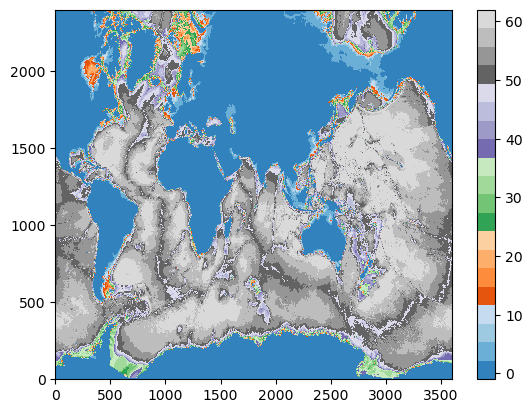

In [20]:
plt.pcolormesh(KMT, cmap='tab20c')
plt.colorbar()